# Training ML models

In [17]:
import pandas as pd
import os
import time
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix

In [18]:
ds=pd.read_csv('./final_dataset.csv')
ds.dropna(subset=['text'], inplace=True)
ds.head()

,text,emotion
0,i should be having more fun doing more and fee...,fun
1,We write to express astonishment at the standa...,surprise
2,i feel my heart is aching though it doesnt bea...,neutral
3,happy mother's day!,surprise
4,i feel satisfied when i create something satis...,enthusiasm


### Splitting dataset

In [19]:
X=ds['text']
y=ds['emotion']
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=1)

### Vectorizing dataset

In [20]:
vectorizer=TfidfVectorizer(token_pattern=r'(?u)\b\w+\b')#pattern to consider single letter ('a') as a feature (word)

### Confusion Matrix

In [21]:
def plot_confusion_matrix(y_true, y_pred, model_name, labels):
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    plt.figure(figsize=(8, 8))  # Make the figure larger
    sns.heatmap(cm, annot=True, fmt='d', cmap='Reds', xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(f'Confusion Matrix for {model_name}')
    plt.show()

## Linear Model

> Logistic Regression



### L1 (Custom)

In [22]:
print("MODEL1: L1 penalty with liblinear solver")
start_time = time.time()
Logistic_Pipeline_L1 = Pipeline([
    ('vectorizer', vectorizer),
    ('classifier', LogisticRegression(max_iter=1000, C=1.0,  #Default for Logistic Regression
                                      penalty='l1',
                                      solver='liblinear',  #Default for L1
                                      random_state=1
                                      ))
])
Logistic_Pipeline_L1.fit(X_train, y_train)
end_time = time.time()
tot_time = end_time - start_time
y_pred_L1 = Logistic_Pipeline_L1.predict(X_test)
accuracy_L1 = accuracy_score(y_test, y_pred_L1)
print(f"Accuracy: {100 * accuracy_L1:.4f}%")
print(f"Training time: {tot_time:.4f}s")
class_names = Logistic_Pipeline_L1.named_steps['classifier'].classes_
report_L1 = classification_report(y_test, y_pred_L1, target_names=class_names)

MODEL1: L1 penalty with liblinear solver


C:\Users\13400f_RTX4060ti\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_logistic.py:1296: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.
  warnings.warn(


Accuracy: 86.0333%
Training time: 4.1380s


### L2 (Default)

In [23]:
print("MODEL2: L2 penalty with lbfgs solver")
start_time=time.time()
Logistic_Pipeline_L2=Pipeline([
    ('vectorizer',vectorizer),
    ('classifier',LogisticRegression(max_iter=1000,C=1.0,#Default for Logistic Regression
                                         penalty='l2',#Default for Logistic Regression
                                         solver='lbfgs', #Default for L2
                                         random_state=1
                                         ))
])
Logistic_Pipeline_L2.fit(X_train,y_train)
end_time=time.time()
tot_time=end_time-start_time
y_pred_L2=Logistic_Pipeline_L2.predict(X_test)
accuracy_L2=accuracy_score(y_test,y_pred_L2)
print(f"Accuracy: {100*accuracy_L2:.4f}%")
print(f"Training time: {tot_time:.4f}s")
report_L2=classification_report(y_test,y_pred_L2,target_names=class_names)

MODEL2: L2 penalty with lbfgs solver
Accuracy: 85.1072%
Training time: 11.3229s


### Stiff model (Low C value)
Default L2 penalty and solver

In [24]:
print("MODEL3: Low C score for a stiff model")
start_time=time.time()
Logistic_Pipeline_C=Pipeline([
    ('vectorizer',vectorizer),
    ('classifier',LogisticRegression(max_iter=1000,C=0.1,random_state=1))
])
Logistic_Pipeline_C.fit(X_train,y_train)
end_time=time.time()
tot_time=end_time-start_time
y_pred_C=Logistic_Pipeline_C.predict(X_test)
accuracy_C=accuracy_score(y_test,y_pred_C)
print(f"Accuracy: {100*accuracy_C:.4f}")
print(f"Training time: {tot_time:.4f}s")
report_C=classification_report(y_test,y_pred_C,target_names=class_names)

MODEL3: Low C score for a stiff model
Accuracy: 80.3357
Training time: 6.5197s


In [25]:
joblib.dump(Logistic_Pipeline_L1,'Logistic_Regression_L1.joblib')
joblib.dump(Logistic_Pipeline_L2,'Logistic_Regression_L2.joblib')
joblib.dump(Logistic_Pipeline_C,'Logistic_Regression_C.joblib')

['Logistic_Regression_C.joblib']

I trained 3 different variants of the Logistic Regression model.

1. Model 1: This variant uses the L1 norm penalty (Lasso) along with the compatible liblinear solver owing to the huge vocabulary vector of the model. Has a default penalty strength value (C=1.0)

2. Model 2: This variant uses the L2 norm (Ridge) along with the lbfgs solver and as expected takes longer to train compared to the L1 varaint. Has a default penalty strength value (C=1.0)

3. Model 3: This variant has the default hyperparameters (Ridge and lbfgs) but a low penalty strength (C=0.1). This penatly strength determines how "flexible" the hyperplane is. Lower the score lower the flexiility meaning less prone to overfitting but more prone to underfitting.


The magnitude of the penalty strength and the "stiffness" is actually directly proportional in theory and in other ML libraries but in sklearn its inversely proportinal. Hence I used the term flexibility instead of stiffness in order to avoid confusion.

## Non Linear Model

> Random Forest Classifier

### Random Forest Classifier

In [26]:
print("Random Forest Classifier")
start_time=time.time()
RFC_Pipeline=Pipeline([
    ('vectorizer',vectorizer),
    ('classifier',RandomForestClassifier(n_estimators=500,n_jobs=-1,max_depth=50,min_samples_split=5,random_state=1))#n_jobs=-1 selects all available CPU cores for tree generation
])
RFC_Pipeline.fit(X_train,y_train)
end_time=time.time()
tot_time=end_time-start_time
y_pred_RFC=RFC_Pipeline.predict(X_test)
accuracy_RFC=accuracy_score(y_test,y_pred_RFC)
print(f"Accuracy: {100*accuracy_RFC:.4f}%")
print(f"Training time: {tot_time:.4f}s")
report_RFC=classification_report(y_test,y_pred_RFC,target_names=class_names)

Random Forest Classifier
Accuracy: 83.6452%
Training time: 39.5602s


In [27]:
joblib.dump(RFC_Pipeline,'RFC_Pipeline.joblib')

['RFC_Pipeline.joblib']

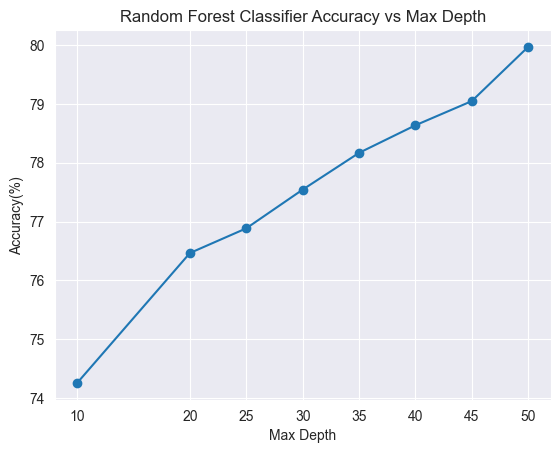

In [28]:
depths = [10,20,25,30,35,40,45,50]
accuracies = [74.2610,76.4658,76.8850,77.5415,78.1655,78.6336,79.0442,79.9639]
plt.plot(depths, accuracies, marker='o',linestyle='-')
plt.xlabel('Max Depth')
plt.ylabel('Accuracy(%)')
plt.xticks(depths)
plt.title('Random Forest Classifier Accuracy vs Max Depth')
plt.grid(True)
plt.show()

The first RFC ensemle had 300 trees which produced as accuracy of 73.5671%
The number of trees were increased from 300 to 500 which resulted in an accuracy of 74.2610% giving a gain of 0.6939%.

I settled with 500 trees and started to increase the max depth. The increments are as follows:

* 10 74.2610% | (Baseline)
* 20 76.4658% | **+2.2048%**
* 30 76.8850% | **+0.4192%**
* 35 78.1655% | **+0.6240%**
* 40 78.6336% | **+0.4681%**
* 45 79.0442% | **+0.4106%**
* 50 79.2946% | **+0.2504%**

I stopped increasing the depth at the earliest sign of a plateau in the depth vs accuracy graph.



# Model evaluation and comparision

### Logistitc Regression Models' Metrics

In [29]:
print(report_L1)

              precision    recall  f1-score   support

       anger       0.91      0.84      0.87      1982
       empty       0.98      0.87      0.92      1286
  enthusiasm       0.98      0.92      0.95      1969
         fun       0.93      0.85      0.89      2083
   happiness       0.76      0.76      0.76      2021
        hate       0.96      0.93      0.94      2003
        love       0.93      0.91      0.92      1987
     neutral       0.86      0.96      0.91      1943
      relief       0.95      0.90      0.92      1994
     sadness       0.64      0.75      0.69      2002
    surprise       0.71      0.77      0.74      2002

    accuracy                           0.86     21272
   macro avg       0.87      0.86      0.87     21272
weighted avg       0.87      0.86      0.86     21272



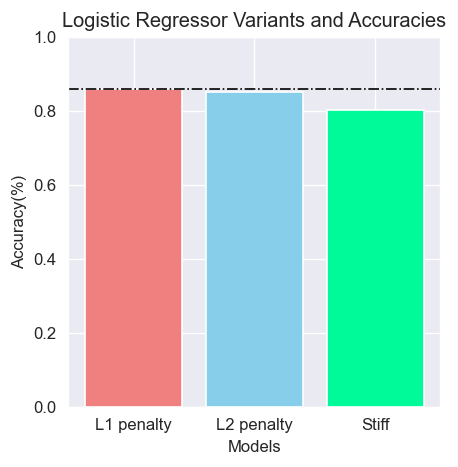

In [30]:
models=['L1 penalty','L2 penalty','Stiff']
training_time=[11.9715,38.4470,14.2927]
accuracies=[accuracy_L1,accuracy_L2,accuracy_C]
colors=['lightcoral','skyblue','mediumspringgreen']
plt.figure(figsize=(4,4),dpi=120)
plt.bar(models,accuracies,color=colors)
plt.axhline(y=accuracy_L1,color='black',linestyle='-.',linewidth=1)
plt.ylim(0,1)
plt.xlabel('Models')
plt.ylabel('Accuracy(%)')
plt.title('Logistic Regressor Variants and Accuracies')
plt.show()

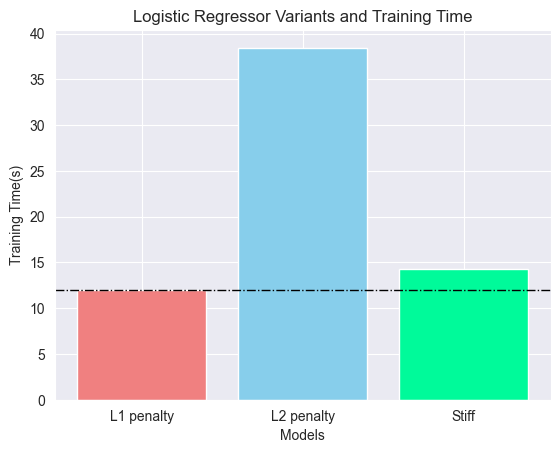

In [31]:
plt.bar(models,training_time,color=colors)
plt.xlabel('Models')
plt.ylabel('Training Time(s)')
plt.title('Logistic Regressor Variants and Training Time')
plt.axhline(y=training_time[0],color='black',linestyle='-.',linewidth=1)
plt.show()

--- Logistic Regression (L1) Confusion Matrix ---


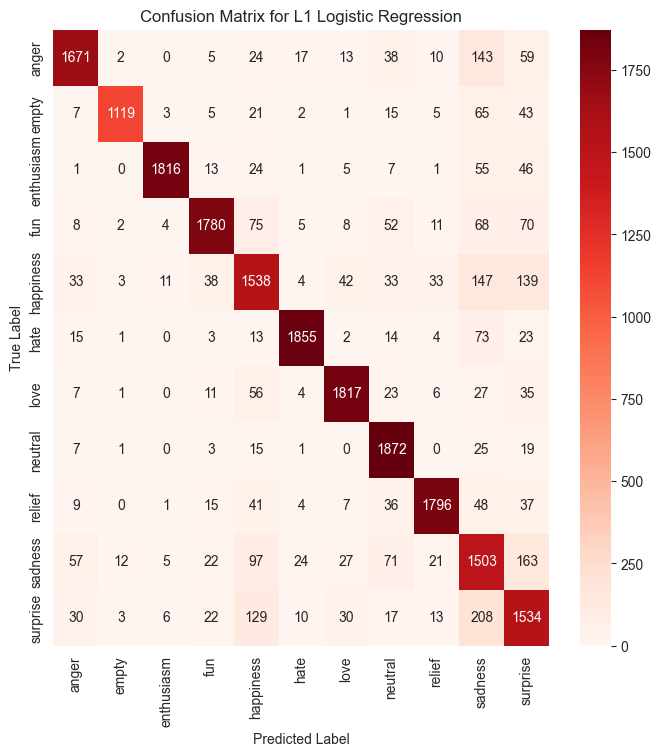

In [32]:
print("--- Logistic Regression (L1) Confusion Matrix ---")
plot_confusion_matrix(y_test, y_pred_L1, 'L1 Logistic Regression', class_names)

### Random Forest Classifier Metrics

--- Random Forest Classifier Confusion Matrix ---


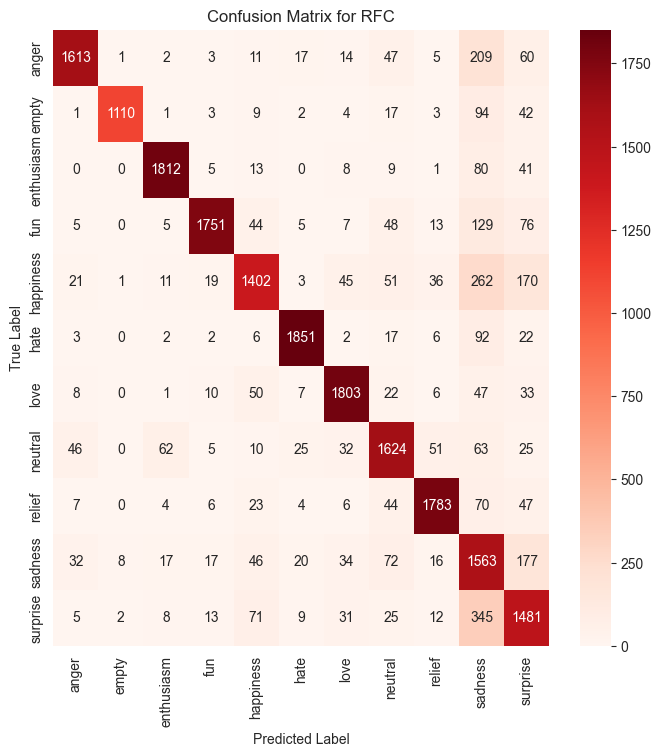

In [33]:
print("--- Random Forest Classifier Confusion Matrix ---")
plot_confusion_matrix(y_test, y_pred_RFC, 'RFC', class_names)

In [34]:
print(report_RFC)

              precision    recall  f1-score   support

       anger       0.93      0.81      0.87      1982
       empty       0.99      0.86      0.92      1286
  enthusiasm       0.94      0.92      0.93      1969
         fun       0.95      0.84      0.89      2083
   happiness       0.83      0.69      0.76      2021
        hate       0.95      0.92      0.94      2003
        love       0.91      0.91      0.91      1987
     neutral       0.82      0.84      0.83      1943
      relief       0.92      0.89      0.91      1994
     sadness       0.53      0.78      0.63      2002
    surprise       0.68      0.74      0.71      2002

    accuracy                           0.84     21272
   macro avg       0.86      0.84      0.84     21272
weighted avg       0.86      0.84      0.84     21272



# Winner and Verdict

In this notebook I attempted to train a Logistic Regression model with 3 variants and a Random Forest Classifier ensemble. While the accuracies look somewhat promising the complete performance report shows the underlying story.

* The first version of the final dataset had "worry" and "fear" emotion. These emotions clashed with sadness a lot so I merged them together and downsampled the new formed sadness to the standard 10k documents size. This massively increased the accuracy of the L1 logistic regression model from 82.7% to 86.2%.
* After the merging of the 2 emotions, both the ***models still struggle with happiness, sadness and surprise*** emotions.
* This may be due to sheer noise introduced by one of the smaller datasets I used
(ds1, ds2, ds3).

* The model that struggles the most is RFC. The precision score for sadness emotion for the RFC model is 0.51, its practically taking a random guess (50/50 chance of being correct).

To try and solve this issue I set up the ngram_range=(1,2) but this ended up hurting the performance of both the models. RFC suffered the most damage, so much so that the precision score for sadness by RFC dropped from 0.51 to 0.44 meaning that it was worse than a random guess. This is most certainly due to the insane increase of the vocabulary vector generated by TF-IDF vectorizer when using unigrams and bigrams.
___

Considering the complexity and accuracy of the models, the winner is Logistic Regression with L1 penalty.
---